In [57]:
import pandas as pd
#pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read the Scraped Dataset, Preprocess and Create Intermediate Dataset

In [44]:
All_Reviews = pd.read_csv(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Combined_Reviews_May20.csv.gz', \
                          compression='gzip', error_bad_lines=False, low_memory=False, parse_dates=['review_created_at'],
                          dtype={'reviewee_id':str,'review_id': str,'reviewer_id':str,'listing_id':str})

In [45]:
All_Reviews.head()
All_Reviews.dtypes

listing_id                            object
reviews_count                          int64
reviewee_deleted                        bool
reviewee_first_name                   object
reviewee_host_name                    object
reviewee_id                           object
reviewee_is_superhost                   bool
review_id                             object
review_created_at        datetime64[ns, UTC]
review_language                       object
review_rating                        float64
review_comments                       object
host_response                         object
reviewer_deleted                        bool
reviewer_first_name                   object
reviewer_host_name                    object
reviewer_id                           object
reviewer_is_superhost                   bool
dtype: object

In [46]:
# Remove all non-english reviews and those on or after 2020-04-01
Reviews = All_Reviews[(All_Reviews.review_language.isin(['en'])) & (All_Reviews['review_created_at']<pd.Timestamp('2020-04-01 00:00:00+0000',tz='UTC'))]

In [49]:
Reviews.head()

,listing_id,reviews_count,reviewee_deleted,reviewee_first_name,reviewee_host_name,reviewee_id,reviewee_is_superhost,review_id,review_created_at,review_language,review_rating,review_comments,host_response,reviewer_deleted,reviewer_first_name,reviewer_host_name,reviewer_id,reviewer_is_superhost
0,19137905,50,False,Tamara,Tamara,107292420.0,False,562159788.0,2019-11-10 18:34:12+00:00,en,4.0,The accommodations were very clean and comfort...,NaN,False,Kathy,Kathy,210298195.0,False
1,19137905,50,False,Tamara,Tamara,107292420.0,False,559161145.0,2019-11-03 21:10:52+00:00,en,5.0,Very clean and pleasant quarters. Her dog is ...,NaN,False,Scott,Scott,119171421.0,False
2,19137905,50,False,Tamara,Tamara,107292420.0,False,551751582.0,2019-10-20 19:14:22+00:00,en,5.0,"Tamara was an excellent host, and Kinzee the a...",NaN,False,Maggie,Maggie,155606721.0,False
3,19137905,50,False,Tamara,Tamara,107292420.0,False,547102183.0,2019-10-14 18:45:18+00:00,en,5.0,"Absolute best value in the area, amazing littl...",NaN,False,Colton,Colton,266853043.0,False
4,19137905,50,False,Tamara,Tamara,107292420.0,False,542485908.0,2019-10-06 17:40:52+00:00,en,4.0,"Flexible host with check out time. Very clean,...",NaN,False,Rohit,Rohit,160009185.0,False


In [47]:
Reviews['review_created_at'].max()

Timestamp('2020-03-31 23:59:51+0000', tz='UTC')

In [48]:
Reviews['review_language'].value_counts()

en    10170692
Name: review_language, dtype: int64

In [57]:
# Reviewee First Name == Reviewee Host Name in all cases
fn = lambda row: row.reviewee_first_name == row.reviewee_host_name # define a function for the new column
col = Reviews.apply(fn, axis=1) # get column data with an index
Reviews = Reviews.assign(reviewee_name_check=col.values) # assign values to column 'c'

Reviews['reviewee_name_check'].value_counts()

In [59]:
# Reviewer First Name == Reviewer Host Name in most cases. Reviewer First Name is missing in some cases

fn = lambda row: row.reviewer_first_name == row.reviewer_host_name # define a function for the new column
col = Reviews.apply(fn, axis=1) # get column data with an index
Reviews = Reviews.assign(reviewer_name_check=col.values) # assign values to column 'c'

Reviews['reviewer_name_check'].value_counts()

True    10170692
Name: reviewee_name_check, dtype: int64

In [64]:
a = Reviews[Reviews['reviewer_name_check'] == False]
a.head(25)

,listing_id,reviews_count,reviewee_deleted,reviewee_first_name,reviewee_host_name,reviewee_id,reviewee_is_superhost,review_id,review_created_at,review_language,...,review_comments,host_response,reviewer_deleted,reviewer_first_name,reviewer_host_name,reviewer_id,reviewer_is_superhost,reviewee_name_compare,reviewee_name_check,reviewer_name_check
869367,18086596,1,False,Anila,Anila,67730125.0,False,343466529.0,2018-10-31 20:18:24+00:00,en,...,Nice room for short-term stay.,NaN,False,NaN,NaN,67667870.0,False,1,True,False
1076900,6404336,56,False,Dora,Dora,33401056.0,False,329764166.0,2018-09-29 20:06:52+00:00,en,...,You would never expect greater living experien...,NaN,False,NaN,NaN,67667870.0,False,1,True,False
1831450,38585,138,False,Evelyne,Evelyne,165529.0,False,198797.0,2011-03-14 16:32:19+00:00,en,...,I really enjoyed Evelyne's welcoming and bubbl...,NaN,True,NaN,NaN,411638.0,False,1,True,False
3267349,14554541,112,False,John,John,90105810.0,False,234143325.0,2018-02-11 22:30:06+00:00,en,...,We loved it! Will definitely book again!,NaN,False,NaN,NaN,77796150.0,False,1,True,False
3430159,13398692,190,False,Nick,Nick,21152610.0,False,168629696.0,2017-07-10 01:35:39+00:00,en,...,"Very clean and comfortable, amazing atmosphere...",NaN,False,NaN,NaN,77796150.0,False,1,True,False
3647008,15274853,120,False,Alejandro H.,Alejandro H.,61803002.0,False,198241807.0,2017-09-28 21:55:14+00:00,en,...,Great place would recommend,NaN,True,NaN,NaN,151005983.0,False,1,True,False
4532170,19921907,22,False,Raymond,Raymond,140925407.0,False,251243456.0,2018-04-07 17:41:26+00:00,en,...,The house was very nice and spacious. The inte...,NaN,False,NaN,NaN,170814346.0,False,1,True,False
4890547,14336214,219,False,Brandon & Sarah,Brandon & Sarah,40219782.0,False,279757343.0,2018-06-21 18:47:14+00:00,en,...,"From the Get-go, we felt welcome and great at ...","Hey girl!! Man, 7 degrees? That’s crazy!! We s...",False,NaN,NaN,161698787.0,False,1,True,False
4916600,3710914,356,False,Brady,Brady,10259524.0,False,115989408.0,2016-11-27 14:15:39+00:00,en,...,this house is amazing. My family really love t...,NaN,False,NaN,NaN,24562860.0,False,1,True,False
5647493,26519461,2,False,Michelle,Michelle,187139932.0,False,479009556.0,2019-06-30 17:26:07+00:00,en,...,An excellent staying option near Union Square ...,NaN,False,NaN,NaN,67667870.0,False,1,True,False


In [68]:
print(Reviews[Reviews.duplicated(['review_id'])])

Empty DataFrame
Columns: [listing_id, reviews_count, reviewee_deleted, reviewee_first_name, reviewee_host_name, reviewee_id, reviewee_is_superhost, review_id, review_created_at, review_language, review_rating, review_comments, host_response, reviewer_deleted, reviewer_first_name, reviewer_host_name, reviewer_id, reviewer_is_superhost, reviewee_name_compare, reviewee_name_check, reviewer_name_check]
Index: []

[0 rows x 21 columns]


In [69]:
cols = ['listing_id', 'reviews_count','reviewee_first_name','reviewee_id','review_id', 'review_created_at',\
        'review_comments','reviewer_first_name','reviewer_id']
Reviews = Reviews[cols]

In [70]:
Reviews.head()

,listing_id,reviews_count,reviewee_first_name,reviewee_id,review_id,review_created_at,review_comments,reviewer_first_name,reviewer_id
0,19137905,50,Tamara,107292420.0,562159788.0,2019-11-10 18:34:12+00:00,The accommodations were very clean and comfort...,Kathy,210298195.0
1,19137905,50,Tamara,107292420.0,559161145.0,2019-11-03 21:10:52+00:00,Very clean and pleasant quarters. Her dog is ...,Scott,119171421.0
2,19137905,50,Tamara,107292420.0,551751582.0,2019-10-20 19:14:22+00:00,"Tamara was an excellent host, and Kinzee the a...",Maggie,155606721.0
3,19137905,50,Tamara,107292420.0,547102183.0,2019-10-14 18:45:18+00:00,"Absolute best value in the area, amazing littl...",Colton,266853043.0
4,19137905,50,Tamara,107292420.0,542485908.0,2019-10-06 17:40:52+00:00,"Flexible host with check out time. Very clean,...",Rohit,160009185.0


In [71]:
Reviews.to_csv (r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_Intermediate.csv.gz', index = None, header=True, compression='gzip')

# Read the Intermediate Dataset, Preprocess, and Lemmatize

In [63]:
Reviews = pd.read_csv(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_Intermediate.csv.gz', \
                          compression='gzip', error_bad_lines=False, low_memory=False, parse_dates=['review_created_at'],
                          dtype={'reviewee_id':str,'review_id': str,'reviewer_id':str,'listing_id':str})

In [64]:
# remove nan from comments
Reviews['review_comments'] = Reviews['review_comments'].fillna('')

In [4]:
# remove unwanted characters, numbers and symbols
Reviews['review_comments'] = Reviews['review_comments'].str.replace("[^a-zA-Z#]", " ")

In [5]:
# remove short words (length < 3)
Reviews['review_comments'] = Reviews['review_comments'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [14]:
# make entire text lowercase
Reviews['review_comments'] = Reviews['review_comments'].apply(lambda x: x.lower())

In [20]:
# function to remove stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(review):
    rev = review.split()
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

Reviews['review_comments'] = Reviews['review_comments'].apply(remove_stopwords)

In [65]:
# function to lemmatize
nlp = spacy.load('en', disable=['parser', 'ner'])
nlp.max_length = 1030000 

def lemmatization(review):
    tags=['NOUN', 'ADJ', 'VERB', 'ADV']
    doc = nlp(review)
    output = " ".join([token.lemma_ for token in doc if token.pos_ in tags])
    return output

Reviews['review_comments'] = Reviews['review_comments'].apply(lemmatization)

In [66]:
Reviews.to_csv (r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_Lemmatized.csv.gz',\
                index = None, header=True, compression='gzip')

# Read Lemmatized Dataset, Combine Reviews for Each Host, and Run LDA

In [2]:
Reviews = pd.read_csv(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_Lemmatized.csv.gz', \
                          compression='gzip', error_bad_lines=False, low_memory=False, parse_dates=['review_created_at'],
                          dtype={'reviewee_id':str,'review_id': str,'reviewer_id':str,'listing_id':str})

In [3]:
# Remove Nan s in review comments, split comments, and choose only non blank reviews (lemmatize might have caused blank reviews)
Reviews['review_comments'] = Reviews['review_comments'].fillna('')
Reviews['review_comments'] = Reviews['review_comments'].str.split()
Reviews = Reviews[Reviews['review_comments'].str.len() > 0]

In [8]:
# function to append all reviews in a list
Rev_key =  Reviews.groupby(['listing_id','reviews_count','reviewee_first_name','reviewee_id'])['review_comments'].apply(list).reset_index()

In [12]:
# Remove all listings with multiple reviewee (host) ids
Rev_key[Rev_key.duplicated(subset=['listing_id','reviews_count','reviewee_id'])]
Rev_key = Rev_key.drop_duplicates(['listing_id'], keep = False).reset_index(drop=True)

In [15]:
# Create lda
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

def keyword_lda(rev):
     
    dictionary = corpora.Dictionary(rev)
    doc_term_matrix = [dictionary.doc2bow(rev) for rev in rev]

    # Creating the object for LDA model using gensim library
    LDA = gensim.models.ldamodel.LdaModel

    # Build LDA model
    lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=15, random_state=100, chunksize=1000, passes=50)
    
    # Append 15 keywords from all the 15 topics (signified by -1) 
    lda_topics = lda_model.show_topics(num_topics=-1, num_words=15)
    return lda_topics
    '''
    topics = []

    for topic in lda_topics:
        topics.extend(preprocess_string(topic[1], [lambda x: x.lower(), strip_punctuation, strip_numeric]))
        
    return topics
    '''

Rev_key['review_comments'] = Rev_key['review_comments'].apply(keyword_lda)

In [16]:
Rev_key.to_csv (r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_LDA.csv.gz', index = None, header=True, compression='gzip')

# Read LDA Dataset and Extract Keywords

In [58]:
Rev_LDA = pd.read_csv(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_LDA.csv.gz', \
                      compression='gzip', error_bad_lines=False, low_memory=False, dtype={'reviewee_id':str,'listing_id':str})

In [59]:
Rev_LDA.head()

,listing_id,reviews_count,reviewee_first_name,reviewee_id,review_comments
0,10000216,51,Ana,49633363.0,"[(0, '0.039*""house"" + 0.037*""nice"" + 0.025*""ho..."
1,10000222,37,Tressa,4066011.0,"[(0, '0.048*""air"" + 0.032*""room"" + 0.024*""woul..."
2,10000255,24,Irina,6205097.0,"[(0, '0.055*""room"" + 0.037*""take"" + 0.037*""cou..."
3,10000435,3,Ann,51373796.0,"[(0, '0.086*""great"" + 0.045*""first"" + 0.045*""p..."
4,10000726,35,Phil,51375787.0,"[(0, '0.043*""clean"" + 0.022*""nice"" + 0.022*""de..."


In [99]:
# Check for safety related words and return what fraction of total keywords they make up

from nltk import FreqDist
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

safety_list = ['safe', 'safety', 'secure', 'security', 'secured', 'shelter', 'sheltered', 'guard', 'guarded',\
               'locked', 'lock', 'private', 'nonpublic', 'privacy', 'protect', 'protected']


# function to plot most frequent terms
def freq_words(comments):
    
    stripped_comments = preprocess_string(comments, [lambda x: x.lower(), strip_punctuation, strip_numeric])

    fdist = FreqDist(stripped_comments)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    a = words_df[words_df['word'].isin(safety_list)]
    total = a['count'].sum()

    '''
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    d = words_df.nlargest(columns="count", n = min(5,len(stripped_comments))) 
    return d
    '''
    return total/len(stripped_comments)

Rev_LDA['safety_freq'] = Rev_LDA['review_comments'].apply(freq_words)

In [115]:
# Check for good host related words and return what fraction of total keywords they make up

from nltk import FreqDist
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

good_host_list = ['charm', 'charming', 'happy', 'nice', 'welcome', 'welcoming', 'friendly', 'amiable', 'kind',\
                  'lovely', 'attractive', 'pleasant', 'pleasure', 'courteous', 'delight', 'delightful', 'grace', \
                  'graceful', 'gracious', 'invite', 'inviting', 'polite', 'accommodating', 'manner', 'mannered', \
                  'affable', 'affection', 'affectionate', 'engaging', 'sweet', 'pretty', 'adorable', 'comely',\
                  'gorgeous', 'mesmerize', 'mesmerizing', 'allure', 'alluring']


# function to plot most frequent terms
def freq_words(comments):
    
    stripped_comments = preprocess_string(comments, [lambda x: x.lower(), strip_punctuation, strip_numeric])

    fdist = FreqDist(stripped_comments)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    a = words_df[words_df['word'].isin(good_host_list)]
    total = a['count'].sum()

    '''
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    d = words_df.nlargest(columns="count", n = min(5,len(stripped_comments))) 
    return d
    '''
    return total/len(stripped_comments)

Rev_LDA['good_host_freq'] = Rev_LDA['review_comments'].apply(freq_words)

In [92]:
b = Rev_LDA[0:100].copy()

#a = Rev_LDA[Rev_LDA['reviews_count']==1]
#print(b)

#a = Rev_LDA.at[27,'review_comments']

In [107]:
a = Rev_LDA[Rev_LDA['safety_freq']>0]

<Figure size 432x288 with 0 Axes>

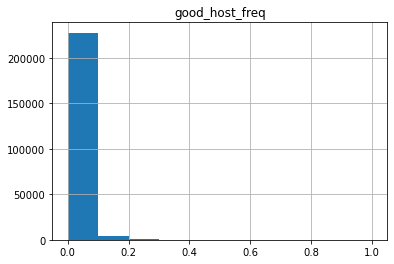

<Figure size 432x288 with 0 Axes>

In [116]:
Rev_LDA.hist(column='good_host_freq')#, bins=100,figsize = [20.0, 5.0])
#ylabel("Number of Listings")
#xlabel("Picture Count")
#xlim([0, 1])
plt.figure()

In [110]:
Rev_LDA.rename(columns={"good_host_list": "good_host_freq"}, errors="raise")

,listing_id,reviews_count,reviewee_first_name,reviewee_id,review_comments,safety_freq,good_host_freq
0,10000216,51,Ana,49633363.0,"[(0, '0.039*""house"" + 0.037*""nice"" + 0.025*""ho...",0.004444,0.017778
1,10000222,37,Tressa,4066011.0,"[(0, '0.048*""air"" + 0.032*""room"" + 0.024*""woul...",0.000000,0.022222
2,10000255,24,Irina,6205097.0,"[(0, '0.055*""room"" + 0.037*""take"" + 0.037*""cou...",0.017778,0.053333
3,10000435,3,Ann,51373796.0,"[(0, '0.086*""great"" + 0.045*""first"" + 0.045*""p...",0.000000,0.000000
4,10000726,35,Phil,51375787.0,"[(0, '0.043*""clean"" + 0.022*""nice"" + 0.022*""de...",0.004444,0.013333
...,...,...,...,...,...,...,...
233363,9999153,147,Jamie & Scott,51367571.0,"[(0, '0.031*""stay"" + 0.024*""place"" + 0.020*""wo...",0.017778,0.017778
233364,9999351,40,Paula,51368588.0,"[(0, '0.043*""apartment"" + 0.029*""would"" + 0.02...",0.004444,0.040000
233365,9999670,248,Donald,7319703.0,"[(0, '0.032*""place"" + 0.024*""great"" + 0.023*""s...",0.008889,0.026667
233366,999977,2,Jennifer,5497326.0,"[(0, '0.067*""arrival"" + 0.067*""automate"" + 0.0...",0.000000,0.000000


In [117]:
Rev_LDA.to_csv (r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_Word_Indicators.csv.gz', index = None, header=True, compression='gzip')

In [217]:
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=doc_term_matrix, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  -4.466049926535265


In [190]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.065762  0.022551       1        1  29.300999
12    -0.014172  0.001972       2        1  16.740448
0     -0.208732  0.006232       3        1  13.007010
3      0.113254  0.156654       4        1  12.457290
4     -0.113520  0.116491       5        1   8.668496
1      0.099595  0.020709       6        1   3.954032
8      0.032066 -0.047001       7        1   3.580549
6     -0.015683 -0.111270       8        1   3.116683
10     0.046929 -0.020042       9        1   3.085420
14     0.007244 -0.028608      10        1   1.762644
5      0.031771 -0.049756      11        1   1.641220
7      0.024765 -0.020941      12        1   0.983230
13     0.030426 -0.013681      13        1   0.790675
11     0.027591 -0.008654      14        1   0.730637
2      0.004229 -0.024655      15        1   0.180673, topic_info=            Term       Freq      Total Category  logprob  loglift
5          great  12.000000  12.000000  Default  30.0000  30.0000
14          stay  17.000000  17.000000  Default  29.0000  29.0000
7           home  15.000000  15.000000  Default  28.0000  28.0000
24          nice   8.000000   8.000000  Default  27.0000  27.0000
9       location  12.000000  12.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
126     driveway   0.004778   2.248041  Topic15  -6.4377   0.1625
287        owner   0.004778   4.879734  Topic15  -6.4377  -0.6125
124           do   0.004778   1.385111  Topic15  -6.4377   0.6468
119  communicate   0.004778   3.071609  Topic15  -6.4377  -0.1496
135           go   0.004778   4.248301  Topic15  -6.4377  -0.4739

[820 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
209       1  0.219943    able
209       2  0.439887    able
209       5  0.219943    able
209       7  0.219943    able
0         1  0.347399  access
...     ...       ...     ...
17        9  0.079337   would
77        2  0.415601   wrong
77        6  0.415601   wrong
208       1  0.434141    year
208       8  0.434141    year

[768 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 13, 1, 4, 5, 2, 9, 7, 11, 15, 6, 8, 14, 12, 3])

In [87]:
Rev_key.to_csv (r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_Key_v1.csv.gz', index = None, header=True, compression='gzip')

0    perfect easy access many location cozy decorat...
Name: review_comments, dtype: object


[Text(0, 0.5, 'Count')]

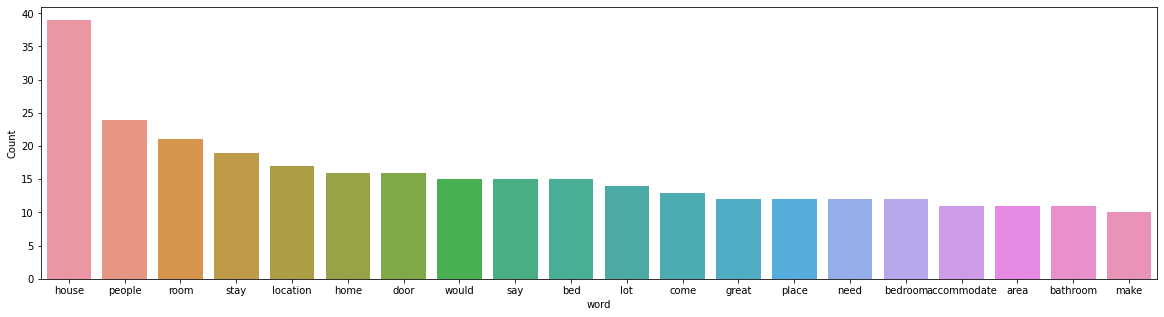

In [140]:
from nltk import FreqDist

b = Rev_key[0:1]
print(b.review_comments)

# function to plot most frequent terms
def freq_words(x):
    all_words = x.split()
    #print(all_words)
    fdist = FreqDist(all_words)
    #words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    return words_df

rev = b.at[0,'review_comments']
words_df = freq_words(rev)

d = words_df.nlargest(columns="count", n = 20) 
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "word", y = "count")
ax.set(ylabel = 'Count')
#figure()

# Plot Most Frequent Terms